## Example B - MNIST & CNN

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 27 April 2023

### Code

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import swyft
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

For this example we don't have a simulator, but we will use the traditional MNIST dataset, which are 60000 28x28 images of hand-written digits between 0 and 9. Here we load training and testing data.

In [ ]:
mnist_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
          transform=torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(  # normalize data to 0 mean and 1 std
                  (0.1307,), (0.3081,)),
              torchvision.transforms.RandomRotation(90.) # Add a random rotation to the image between 0 and 90 degrees        
          ])),
    batch_size=1000, shuffle=True) # shuffle data for new epochs

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



We can have a quick look at the data shapes and sample sizes

In [ ]:
examples = list(mnist_loader)
print("N(batches) =", len(examples))
example_data, example_targets = examples[0]
print(example_data.shape) # number of samples in batch, number of channels here BW so 1, height, width
print(example_targets.shape) # index of sample

N(batches) = 60
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


And again plot a range of examples to check the labels and images. Note that we have added something a bit more complicated here compared to the vanilla dataset - each image is rotated by a random angle between 0 and 90 degrees. We will come back to this later in reference to network architectures.

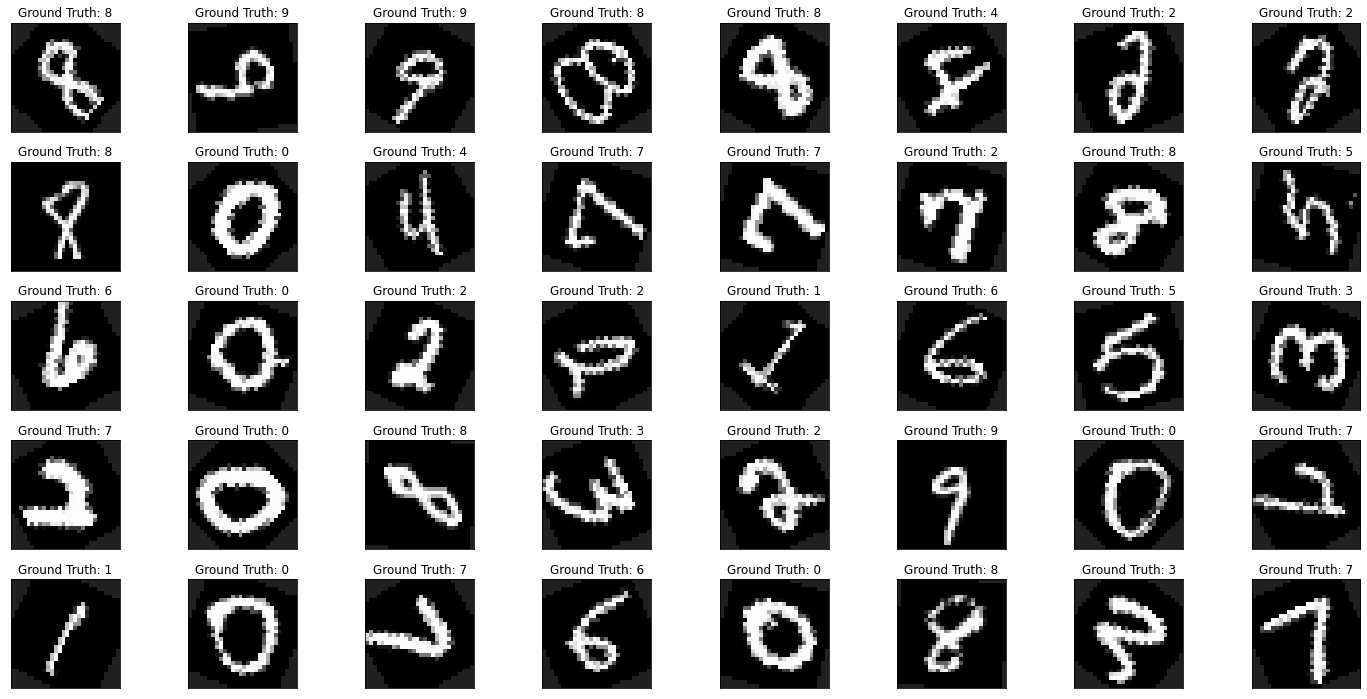

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

We can now build a Swyft simulator to effectively act as an enhanced data loader. This will allow us to easily couple it to a trainer for inference.

In [ ]:
class Simulator(swyft.Simulator):
    def __init__(self, MNIST_dataset):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.num_batches = len(MNIST_dataset)
        self.batch_size = len(MNIST_dataset[0][1])
        self.final_batch_size = len(MNIST_dataset[-1][1])
        self.dataset = MNIST_dataset

    def build(self, graph):
        batch_no = graph.node('batch_no', self.get_batch_no)
        example_no = graph.node('example_no', self.get_example_no, batch_no)
        z = graph.node('z', self.get_z, batch_no, example_no)
        img = graph.node('img', self.get_img, batch_no, example_no)
    
    def get_batch_no(self):
        return np.array([np.random.randint(0, self.num_batches)])
  
    def get_example_no(self, batch_no):
        if batch_no == self.num_batches - 1:
            return np.array([np.random.randint(0, self.final_batch_size)])
        else:
            return np.array([np.random.randint(0, self.batch_size)])
    
    def get_z(self, batch_no, example_no):
        return self.dataset[batch_no[0]][1][example_no[0]]
    
    def get_img(self, batch_no, example_no):
        return self.dataset[batch_no[0]][0][example_no[0]]

In [ ]:
mnist_dataset = list(mnist_loader)
mnist_sim = Simulator(mnist_dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

Label: 4


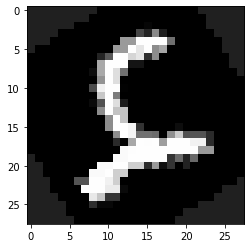

In [ ]:
sample = mnist_sim.sample(10)
print('Label:', sample['z'][0])
plt.imshow(sample['img'][0][0], cmap='gray', interpolation='none');

In [ ]:
sim = Simulator(list(mnist_loader))
shapes, dtypes = sim.get_shapes_and_dtypes()
store = swyft.ZarrStore("./mnist_zarr_store_rotated")
store.init(30000, 64, shapes, dtypes)
store.simulate(sim, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's see how a CNN embedding network perform:

In [ ]:
class Network(swyft.SwyftModule):
    def __init__(self, lr = 1e-3, gamma = 1.):
        super().__init__()
        self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = lr),
              torch.optim.lr_scheduler.ExponentialLR, dict(gamma = gamma))
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 10, num_params = 1, varnames = 'z', dropout = 0.0)
        self.net = torch.nn.Sequential(
          torch.nn.Conv2d(1, 10, kernel_size=5),
          torch.nn.MaxPool2d(2),
          torch.nn.ReLU(),
          torch.nn.Conv2d(10, 20, kernel_size=5, padding=2),
          torch.nn.MaxPool2d(2),
          torch.nn.ReLU(),
          torch.nn.Flatten(),
          torch.nn.Linear(720, 50),
          torch.nn.ReLU(),
          torch.nn.Linear(50, 10),
        )

    def forward(self, A, B):
        img = torch.tensor(A['img']).float()
        z = torch.tensor(B['z']).float()
        f = self.net(img)
        logratios = self.logratios(f, z.unsqueeze(1))
        return logratios

8


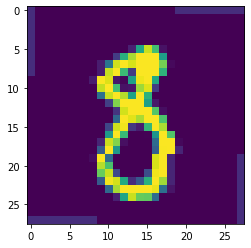

In [ ]:
obs = swyft.Sample(store[0])
plt.imshow(obs['img'][0])
print(obs['z'])

In [ ]:
dm = swyft.SwyftDataModule(store[1:], fractions = [0.7, 0.2, 0.1], batch_size = 32)
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=7, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='.', filename='mnist_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 30, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback],)
network = Network()
trainer.fit(network, dm)
prior_samples = sim.sample(N = 10000, targets = ['z'])
predictions = trainer.infer(network, obs, prior_samples)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 18.0 K
1 | net       | Sequential             | 41.8 K
-----------------------------------------------------
59.8 K    Trainable params
0         Non-trainable params
59.8 K    Total params
0.239     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-10-f13a6380a984>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(A['img']).float()
<ipython-input-10-f13a6380a984>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(B['z']).float()


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Predicting: 657it [00:00, ?it/s]

We can check the performance by evaluating the mean test loss.

In [ ]:
trainer.test(network, dm)

Testing: 0it [00:00, ?it/s]

<ipython-input-10-f13a6380a984>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(A['img']).float()
<ipython-input-10-f13a6380a984>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(B['z']).float()


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.8714231848716736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -0.8714231848716736}]

Classification predictions can be extracted using `get_class_probs`.

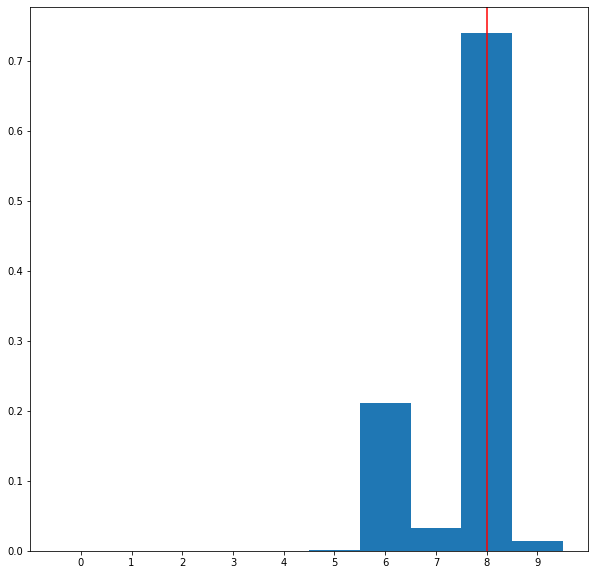

In [ ]:
probs = swyft.get_class_probs(predictions, 'z[0]')
fig, axes = plt.subplots(1, 1, figsize=(10,10))
#swyft.plot_1d(predictions, parname='z[0]')
plt.bar(np.linspace(0, 9, 10), probs, width = 1., log = False)
plt.axvline(obs['z'], c='r');
plt.xticks(np.linspace(0, 9, 10));

### Exercises

1. Replace the CNN by a single linear layer (you can use "flatten" as part of the solution), and check the test loss performance again. The network still learns, but the test loss will (should) not decrease as much as in the CNN case.

In [ ]:
# Results here

2. Add some sort of noise to the simulator e.g. a blob or a PSF. Investigate how this affects the inference results. What happens if you resample this noise as in the rings example?

In [ ]:
# Results here